In [67]:
import datetime as dt
from statistics import mean
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm
from joblib import Parallel, delayed
import portion as P
length_packet = 362

def rtt_plot(df):
    l1 = []
    l2 = []
    for i in tqdm(range(len(df))):
        if not np.isnan(df.loc[i, "tcp.analysis.ack_rtt"]):
            l1.append(df.loc[i, "frame.time"])
            l2.append(df.loc[i, "tcp.analysis.ack_rtt"])
    print("mean:", np.mean(l2))
    plt.plot(l1, l2)
    plt.show()



def get_seq_time():
    rxdf = pd.read_csv(rx_pcap, sep='@')
    rxdf.loc[:, "frame.time"] = pd.to_datetime(rxdf.loc[:, r"frame.time"]).dt.tz_localize(None)
    # map seq to time
    
    rseq_time_list  = []
    tseq_time_list  = []

    for i in tqdm(range(len(rxdf))):
        if rxdf.loc[i, "tcp.len"] >= length_packet and rxdf.loc[i, "ip.src"] == "140.112.20.183":
            bias = rxdf.loc[i, "tcp.payload"].find("0000000062")
            dup_num = (rxdf.loc[i, "tcp.len"] -bias) // length_packet
            packet_time = rxdf.loc[i, "frame.time"]
            for j in range(dup_num):
                seq = int(rxdf.loc[i, "tcp.payload"][bias+32+j*length_packet*2:bias+48+j*length_packet*2], 16)
#                 print(seq)
                rseq_time_list.append((seq, packet_time))

def get_client_ul_seq(txdf):
    length_packet = 362
    tseq_time_dict = {}
    ip_set = set(txdf.loc[:, "ip.src"])
    ip_set.remove("140.112.20.183")
    for i in tqdm(range(len(txdf))):
        if txdf.loc[i, "tcp.len"] >= length_packet and txdf.loc[i, "ip.dst"] == "140.112.20.183":
            bias = txdf.loc[i, "tcp.payload"].find("0000018")
            if bias == -1:
                continue
            dup_num = (txdf.loc[i, "tcp.len"] -bias) // length_packet
            packet_time = txdf.loc[i, "frame.time"]
            for j in range(dup_num):
                seq = int(txdf.loc[i, "tcp.payload"][bias+16+j*length_packet*2:bias+24+j*length_packet*2], 16)
                born_time = int(txdf.loc[i, "tcp.payload"][bias+j*length_packet*2:bias+16+j*length_packet*2], 16)/1000
                born_time = dt.datetime.fromtimestamp(born_time)
                delay = (packet_time - born_time).total_seconds()
                if delay > 0:
                    key = (txdf.loc[i, "ip.src"] , txdf.loc[i, "tcp.srcport"],)
                    if key not in tseq_time_dict:
                        tseq_time_dict[key] = []
                    tseq_time_dict[key].append((seq, packet_time, delay, txdf.loc[i, "frame.number"]))
    for key in tseq_time_dict:
        tseq_time_dict[key].sort(key = lambda x:x[0])
        
    return tseq_time_dict

def get_server_ul_seq(rxdf):
    length_packet = 362
    rseq_time_dict = {}
    for i in tqdm(range(len(rxdf))):
        if rxdf.loc[i, "tcp.len"] >= length_packet:
            bias = rxdf.loc[i, "tcp.payload"].find("0000018")
            if bias == -1:
                continue
            dup_num = (rxdf.loc[i, "tcp.len"] -bias) // length_packet
            packet_time = rxdf.loc[i, "frame.time"]
            for j in range(dup_num):
                seq = int(rxdf.loc[i, "tcp.payload"][bias+16+j*length_packet*2:bias+24+j*length_packet*2], 16)
                born_time = int(rxdf.loc[i, "tcp.payload"][bias+j*length_packet*2:bias+16+j*length_packet*2], 16)/1000
                born_time = dt.datetime.fromtimestamp(born_time)
                delay = (packet_time - born_time).total_seconds()
                if delay > -10:
                    key = (rxdf.loc[i, "ip.src"] , rxdf.loc[i, "tcp.srcport"],)
                    if key not in rseq_time_dict:
                        rseq_time_dict[key] = []
                    rseq_time_dict[key].append((seq, packet_time, delay, rxdf.loc[i, "frame.number"]))
    for key in rseq_time_dict:
        rseq_time_dict[key].sort(key = lambda x:x[0])
        
    return rseq_time_dict

def get_ret(pcapdf):
    # get retransmision time list
    time_list = []
    for i in range(len(pcapdf)):
        if "Retran" in pcapdf.loc[i, "_ws.col.Info"]:
            time_list.append(pcapdf.loc[i, "frame.time"])
    time_list = pd.to_datetime(time_list)
    return time_list


def latency_impulse(latency_list, t):
    return sum(latency_list[:, 0] > t) / len(latency_list)

def read_pcapcsv(filename):
    df = pd.read_csv(filename, sep='@')
    df.loc[:, "frame.time"] = pd.to_datetime(df.loc[:, r"frame.time"]).dt.tz_localize(None)
    return df

def UL_latency(rseq_time_list, tseq_time_list):
    latency_list = []
    i = 0
    j = 0
    
    while i < len(rseq_time_list) and j < len(tseq_time_list):
        
        if rseq_time_list[i][0] * 100 < tseq_time_list[j][0] or rseq_time_list[i][0] > tseq_time_list[j][0] * 100:
            break

        if rseq_time_list[i][0] < tseq_time_list[j][0]:
            i += 1
        elif rseq_time_list[i][0] > tseq_time_list[j][0]:
            j += 1
        else:
#             print(rseq_time_list[i], tseq_time_list[j])
            latency_list.append(((rseq_time_list[i][1] - tseq_time_list[j][1]).total_seconds(), tseq_time_list[i][1], rseq_time_list[j][0]))
            i += 1
            j += 1
    latency_list = np.array(latency_list)
    latency_list[:, 0] -= latency_list[:, 0].min()
#     latency_list[:, 0] += 0.01
    plt.title("latency")
    plt.ylabel("seconds")
    plt.plot(latency_list[:, 1], latency_list[:, 0])
    plt.show()
    print(len(latency_list))
    print(np.mean(latency_list[:, 0]))
    return latency_list

def mp_latency(l1, l2):
    # (latency, time, seq)
    
    i = 0
    j = 0
    latency_list = []

    
    while i < len(l1) and j < len(l2):
        
        if l1[i][2] * 100 < l2[j][2] or l1[i][2] > l2[j][2] * 100:
            break

        if l1[i][2] < l2[j][2]:
            i += 1
        elif l1[i][2] > l2[j][2]:
            j += 1
        else:
            print(l1[i], l2[j])
            # latency, time, seq
#             print(l1[i][0], l2[j][0], np.min())
            latency_list.append((np.min((l1[i][0], l2[j][0])), l2[j][1], l2[j][2]))
            i += 1
            j += 1
    latency_list = np.array(latency_list)
#     latency_list[:, 0] -= latency_list[:, 0].min()
#     latency_list[:, 0] += 0.01
    plt.title("latency")
    plt.ylabel("seconds")
    plt.plot(latency_list[:, 0], latency_list[:, 2])
    plt.show()
    print(len(latency_list))
    print(np.mean(latency_list[:, 0]))
    return latency_list



In [68]:
def mi_event_parsing(miinfofile, nr_time_intervals):

    nr_pci = None
    
    lte_4G_handover_list = []   #4G 狀態下LTE eNB 的 handover
    
    nr_setup_list = []          #gNB cell addition
    nr_handover_list = []       #gNB cell changes (eNB stays the same)
    nr_removal_list = []        #gNB cell removal
        
    lte_5G_handover_list = []   #(eNB1, gNB1) -> (eNB2, gNB1) #gNB stays the same
    nr_lte_handover_list = []   #both NR cell and LTE cell have handover
    
    scg_failure_list = []       #gNB handover failure
    reestablish_list = []       #eNB handover failure
    
    nr_handover = 0
    nr_handover_start_index = None
    lte_handover = 0
    lte_handover_start_index = None
    nr_release = 0
    nr_release_start_index = None
    
    handover_num = 0
    
    #initialization
    #----------------------------------------------------------------
    if miinfofile.loc[0, "time"] in nr_time_intervals:
        nr_pci = 1000000            #先設置一個數 dummy nr pci
    
    for i in range(len(miinfofile)):       
        if miinfofile.loc[i, "nr-rrc.t304"]:
            if nr_handover == 0:    
                nr_handover = 1
                nr_handover_start_index = i
                
        if miinfofile.loc[i, "lte-rrc.t304"]:
            if lte_handover == 0:
                lte_handover = 1
                lte_handover_start_index = i
                
        if miinfofile.loc[i, "nr-Config-r15: release (0)"]:
            if nr_release == 0:
                nr_release = 1
                nr_release_start_index = i
           
        if (nr_handover or lte_handover or nr_release) and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:
            handover_num +=1
        
        
        #handover 種類分類
        #------------------------------------------------------------------------------
        if lte_handover and not nr_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:  # just lte cell handover event
            lte_handover = 0
            lte_4G_handover_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            
        if nr_handover and not lte_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:  # just nr cell handover event
            nr_handover = 0
            if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]:     #This if-else statement classifies whether it is nr addition or nr handover
                nr_setup_list.append([miinfofile.loc[nr_handover_start_index, "time"], miinfofile.loc[i, "time"]])       
            else:
                nr_handover_list.append([miinfofile.loc[nr_handover_start_index, "time"], miinfofile.loc[i, "time"]])
                
            #additional judgement:
            #----------------------------
            #if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"] and nr_pci != None:
            #    print("Warning: dualConnectivityPHR setup may not mean nr cell addition", mi_file, i)
            #if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]==0 and not (nr_pci != None and nr_pci != miinfofile.loc[nr_handover_start_index, "nr_pci"]): 
            #    print("Warning: nr-rrc.t304 without dualConnectivityPHR setup may not mean nr cell handover", mi_file, i, nr_handover_start_index, miinfofile.loc[nr_handover_start_index, "nr_pci"], nr_pci)
                
            #nr_pci update lte_handover_start_time
            nr_pci = miinfofile.loc[nr_handover_start_index, "nr_pci"]
            
            
        if lte_handover and nr_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:      # both nr cell and lte cell handover event
            lte_handover = 0
            nr_handover = 0
            if nr_pci == miinfofile.loc[lte_handover_start_index, "nr_pci"]:
                lte_5G_handover_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            else:
                nr_lte_handover_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            
            #nr_pci update
            nr_pci = miinfofile.loc[lte_handover_start_index, "nr_pci"]
            
        if nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:
            nr_pci = None
            nr_release=0
            nr_removal_list.append([miinfofile.loc[nr_release_start_index, "time"], miinfofile.loc[i, "time"]])
        if miinfofile.loc[i, "scgFailureInformationNR-r15"]:
            scg_failure_list.append([miinfofile.loc[i, "time"], miinfofile.loc[i, "time"]])
        if miinfofile.loc[i, "rrcConnectionReestablishmentRequest"]:
            reestablish_list.append([miinfofile.loc[i, "time"], miinfofile.loc[i, "time"]])
            
    return [lte_4G_handover_list, nr_setup_list, nr_handover_list, nr_removal_list, lte_5G_handover_list, nr_lte_handover_list, scg_failure_list, reestablish_list], handover_num

#This function firstly generates three intervals for each [handover_start, handover_end] in handover_list
#   a. before the handover_start event: [handover_start-second, handover_start]
#   b. during the handover events: [handover_start, handover_end]
#   c. after the handover_end event: [handover_end, handover_end+second]
#Then, it returns the overall intervals before/during/after the handover event
#--------------------------------------------------------------------
def get_before_during_after_intervals(handover_list, second):
    before_handover_intervals = P.empty()
    handover_intervals = P.empty()
    after_handover_intervals = P.empty()
    for i in range(len(handover_list)):  
        interval = P.closed( handover_list[i][0]-dt.timedelta(seconds=second), handover_list[i][0] )
        before_handover_intervals = before_handover_intervals | interval
        
        interval = P.closed( handover_list[i][0], handover_list[i][1] )
        handover_intervals = handover_intervals | interval
        
        interval = P.closed( handover_list[i][1], handover_list[i][1]+dt.timedelta(seconds=second) )
        after_handover_intervals = after_handover_intervals | interval    
    return before_handover_intervals, handover_intervals, after_handover_intervals
   
#This function returns the overall length of the intervals
#--------------------------------------------------------------------
def get_sum_intervals(intervals):
    if intervals.empty:
        return 0
    sum = 0
    for x in intervals:
        sum += (x.upper - x.lower)/dt.timedelta(seconds=1)
    return sum

event_names = [
    "lte_4G_handover",
    "nr_setup",
    "nr_handover",
    "nr_removal",
    "lte_5G_handover",
    "nr_lte_handover_list",
    "scg_failure",
    "reestablish"
]

column_names = []

for i in range(len(event_names)-2):
    column_names += ["before_"+event_names[i]+"_intervals", "during_"+event_names[i]+"_intervals", "after_"+event_names[i]+"_intervals"]
for i in range(len(event_names)-2, len(event_names)):
    column_names += ["before_"+event_names[i]+"_intervals", "after_"+event_names[i]+"_intervals"]
    
column_names += ["nr_time_intervals", "weak_nr_intervals", "weak_lte_intervals"]
print("column_names=", column_names)

sum_intervals = [0] * len(column_names)
sum_packet_loss = [0] * len(column_names)
sum_stable_intervals = 0

column_names= ['before_lte_4G_handover_intervals', 'during_lte_4G_handover_intervals', 'after_lte_4G_handover_intervals', 'before_nr_setup_intervals', 'during_nr_setup_intervals', 'after_nr_setup_intervals', 'before_nr_handover_intervals', 'during_nr_handover_intervals', 'after_nr_handover_intervals', 'before_nr_removal_intervals', 'during_nr_removal_intervals', 'after_nr_removal_intervals', 'before_lte_5G_handover_intervals', 'during_lte_5G_handover_intervals', 'after_lte_5G_handover_intervals', 'before_nr_lte_handover_list_intervals', 'during_nr_lte_handover_list_intervals', 'after_nr_lte_handover_list_intervals', 'before_scg_failure_intervals', 'after_scg_failure_intervals', 'before_reestablish_intervals', 'after_reestablish_intervals', 'nr_time_intervals', 'weak_nr_intervals', 'weak_lte_intervals']


In [74]:
dirpath = r"C:\Users\User\Desktop\data\xm04"
cellinfodir = sorted(os.listdir(os.path.join(dirpath, "cellinfo")))
mi2logdir = sorted(os.listdir(os.path.join(dirpath, "mi2log")))
pcapdir = sorted(os.listdir(os.path.join(dirpath, "pcap")))
assert(len(cellinfodir) == len(mi2logdir) == len(pcapdir) )
for cellinfo, mi2log, pcapcsv in zip(cellinfodir, mi2logdir, pcapdir):
    print(cellinfo, mi2log, pcapcsv)

    cellinfofile = pd.read_csv(os.path.join(os.path.join(dirpath, "cellinfo"), cellinfo))
    cellinfofile.loc[:, "Date"] = pd.to_datetime(cellinfofile.loc[:, "Date"])

    miinfofile = pd.read_csv(os.path.join(os.path.join(dirpath, "mi2log"), mi2log))
    miinfofile.loc[:, "time"] = pd.to_datetime(miinfofile.loc[:, "time"]) + dt.timedelta(hours=8)

    pcapdf = read_pcapcsv(os.path.join(os.path.join(dirpath, "pcap"), pcapcsv))
    #======================lost time (and latency)=============================
    # loss_time, latency = get_loss_latency(pcap)
    ret_list = get_ret(pcapdf) 
    #======================before mi event parse, parse NR intervals first=====
    nr_time_intervals = P.empty()
    if cellinfofile.loc[0, "NR_SSRSRP"] != "-":
        nr_time_intervals = P.singleton(cellinfofile.loc[0, "Date"])
    for i in range(1, len(cellinfofile)):
        if cellinfofile.loc[i, "NR_SSRSRP"] != "-":
            nr_time_intervals = nr_time_intervals | P.openclosed(cellinfofile.loc[i-1, "Date"] , cellinfofile.loc[i, "Date"])
    weak_nr_intervals = P.empty()
    if cellinfofile.loc[0, "NR_SSRSRP"] != "-" and int(cellinfofile.loc[0, "NR_SSRSRP"]) <= -90:
        weak_nr_intervals = P.singleton(cellinfofile.loc[0, "Date"])
    for i in range(1, len(cellinfofile)):
        if cellinfofile.loc[i, "NR_SSRSRP"] != "-" and int(cellinfofile.loc[i, "NR_SSRSRP"]) <= -90:
            weak_nr_intervals = weak_nr_intervals | P.openclosed(cellinfofile.loc[i-1, "Date"] , cellinfofile.loc[i, "Date"])
    weak_lte_intervals = P.empty()
    if cellinfofile.loc[0, "LTE_RSRP"] != "-" and int(cellinfofile.loc[0, "LTE_RSRP"]) <= -90:
        weak_lte_intervals = P.singleton(cellinfofile.loc[0, "Date"])
    for i in range(1, len(cellinfofile)):
        if cellinfofile.loc[i, "LTE_RSRP"] != "-" and int(cellinfofile.loc[i, "LTE_RSRP"]) <= -90:
            weak_lte_intervals = weak_lte_intervals | P.openclosed(cellinfofile.loc[i-1, "Date"] , cellinfofile.loc[i, "Date"])

    #======================mi event parse======================================  
    handover_event_lists, handover_num = mi_event_parsing(miinfofile, nr_time_intervals)

    #======================making intervals====================================
    intervals = []

    for handover_event_list in handover_event_lists[:-2]:
        before_intervals, during_intervals, after_intervals = get_before_during_after_intervals(handover_event_list, 1)     #抓取前後一秒
        intervals += [before_intervals, during_intervals, after_intervals].copy()
    for handover_event_list in handover_event_lists[-2:]:
        before_intervals, _, after_intervals = get_before_during_after_intervals(handover_event_list, 3)                    #抓取前後三秒
        intervals += [before_intervals, after_intervals].copy()    

    intervals += [nr_time_intervals, weak_nr_intervals, weak_lte_intervals]
    #================================judgement=================================
    out = pd.DataFrame(columns = column_names, dtype=object)

    #------check time-------
    start_time = miinfofile.loc[0, "time"]
    if cellinfofile.loc[0, "Date"] > start_time:
        start_time = cellinfofile.loc[0, "Date"]
#     if latency[0][0] > start_time:
#         start_time = latency[0][0]
    end_time = miinfofile.loc[len(miinfofile)-1, "time"]
    if cellinfofile.loc[len(cellinfofile)-1, "Date"] < end_time:
        end_time = cellinfofile.loc[len(cellinfofile)-1, "Date"]
#     if latency[0][-1] < end_time:
#         end_time = latency[0][-1]
    ###
    
    for loss_index in range(len(ret_list)):    
        if ret_list[loss_index] < start_time:
            continue
        if ret_list[loss_index] > end_time:
            continue

        types = [0]*len(intervals)
        for i in range(len(intervals)):
            if ret_list[loss_index] in intervals[i]:
                types[i] = 1
        out.loc[loss_index] = types                
    #output: number of packet loss, number of packet loss under each type, handover num, overall experiment time, file names 
    output = [len(out)] + [len(out.loc[ out[column_names[i]]==1 ]) for i in range(len(column_names)-3)] + [handover_num, (end_time-start_time)/dt.timedelta(seconds=1)]
    print(output)



    for i in range(len(column_names)):
        intervals[i] = intervals[i] & P.closed(start_time, end_time)
        sum_intervals[i] += get_sum_intervals(intervals[i])

    stable_intervals = P.closed(start_time, end_time)
    for i in range(len(column_names)-3):
        stable_intervals = stable_intervals - intervals[i]
    sum_stable_intervals += get_sum_intervals(stable_intervals)

    for i in range(len(column_names)-3):
        sum_packet_loss[i] += len(out.loc[ out[column_names[i]]==1 ])

    #User can decide whether save the packet loss classification as csv file
    out.to_csv("all_loss_classify_7.csv", mode='a')

    print(sum_stable_intervals)
    print([sum_intervals[i] for i in range(len(column_names)-3)])
    ratelist = []
    for i in range(len(column_names)-3):
        if sum_intervals[i]:
            ratelist.append(sum_packet_loss[i]/(sum_intervals[i]))
    print(ratelist)
    print("-"*30)

042122080537_new.csv diag_log_20220421_201721_b0e4a15ac89caff782b5f2af1b41b5d2_Xiaomi-M2007J3SY_46697.mi2log.txt_3.csv 2022-4-21-20-04-34_pcap.csv
[100, 0, 0, 0, 36, 0, 14, 0, 7, 2, 0, 6, 6, 3, 0, 4, 0, 0, 0, 0, 0, 3, 39, 59, 677.0]
4670.4404110000005
[28.0, 0.518864, 28.0, 105.70288400000001, 70.91771400000002, 105.70417599999999, 105.279885, 154.82281199999997, 105.23936100000002, 69.665002, 3.7371820000000007, 69.661304, 123.188512, 4.28409, 123.187073, 7.0, 0.251403, 7.0, 3.0, 3.0, 37.772261, 37.772261]
[0.5714285714285714, 1.9272873045730674, 0.21428571428571427, 1.3717695725312469, 0.0282016986616348, 0.7000669491052085, 0.1899698123720405, 0.2648188562806882, 0.2185494075738449, 0.1435440998049494, 5.084044609012886, 0.7751792874850577, 0.21917628163249508, 0.0, 0.2516497814669239, 0.0, 0.0, 0.2857142857142857, 0.3333333333333333, 2.0, 0.5294890872431491, 4.7918762395505]
------------------------------
042122081929_new.csv diag_log_20220421_203616_b0e4a15ac89caff782b5f2af1b41b5d

In [ ]:
rxfile = r"C:\Users\User\Desktop\data\UL_3252.csv"
# txfile = r"C:\Users\User\Desktop\data\UL_3252.csv"

# txdf = read_csv(txfile)
rxdf = read_csv(rxfile)



In [89]:
tseq_time_dict = get_client_ul_seq(txdf)


100%|█████████████████████████████████████████████████████████████████████████| 99276/99276 [00:08<00:00, 11239.95it/s]


In [108]:
rseq_time_dict = get_server_ul_seq(rxdf)

100%|███████████████████████████████████████████████████████████████████████████| 2217/2217 [00:00<00:00, 20911.06it/s]


(49.216.179.104, 192.168.102.40)
(10.196.223.66, 192.168.42.129)

In [90]:
tseq_time_list = []
for ip in tseq_time_dict:
    print(ip, len(tseq_time_dict[ip]))
    tseq_time_list.append(tseq_time_dict[ip])


('192.168.102.152', 40614) 33261
('192.168.1.88', 51615) 86141


In [109]:
rseq_time_list = []
for ip in rseq_time_dict:
    print(ip, len(rseq_time_dict[ip]))
    rseq_time_list.append(rseq_time_dict[ip])

('49.216.226.169', 1210) 1497


In [110]:
rseq_time_dict = get_server_ul_seq(rxdf)

100%|███████████████████████████████████████████████████████████████████████████| 2217/2217 [00:00<00:00, 20907.11it/s]


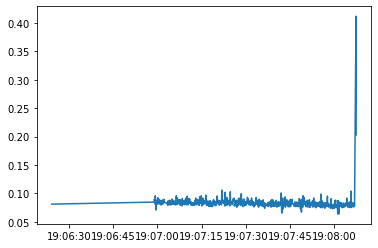

665


In [80]:
x = np.array(np.copy(rseq_time_list[0]))
plt.plot(x[:, 1], x[:, 2])
plt.show()
print(len(x))

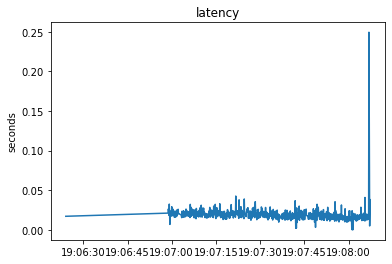

665
0.019488532330827063


In [81]:
l0 = UL_latency(rseq_time_list[0], tseq_time_list[0])

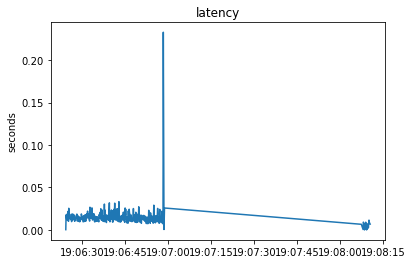

364
0.014670434065934072


In [82]:
l1 = UL_latency(rseq_time_list[1], tseq_time_list[1])

In [73]:
i = 0
j = 0
latency_list = []

while i < len(l1) and j < len(l0):
#     if l1[i][2] * 100 < l0[j][2] or l1[i][2] > l0[j][2] * 100:
#         break

    if l1[i][2] < l0[j][2]:
        i += 1
    elif l1[i][2] > l0[j][2]:
        j += 1
    else:
        print(l1[i][2])
        # latency, time, seq
#             print(l1[i][0], l2[j][0], np.min())
        latency_list.append((np.min((l1[i][0], l0[j][0])), l1[j][1], l0[j][2]))
        i += 1
        j += 1

In [36]:
l0

array([[0.005712999999999999, Timestamp('2022-04-17 17:38:24.208284'), 0],
       [0.022269, Timestamp('2022-04-17 17:38:24.212731'), 1],
       [0.022269, Timestamp('2022-04-17 17:38:24.212731'), 2],
       ...,
       [0.010082, Timestamp('2022-04-17 17:39:17.366451'), 52772],
       [0.010082, Timestamp('2022-04-17 17:39:17.366451'), 52773],
       [0.010082, Timestamp('2022-04-17 17:39:17.366451'), 52774]],
      dtype=object)

In [35]:
l1

array([[0.005209999999999999, Timestamp('2022-04-17 17:38:24.297633'),
        33],
       [0.005209999999999999, Timestamp('2022-04-17 17:38:24.297633'),
        34],
       [0.005209999999999999, Timestamp('2022-04-17 17:38:24.297633'),
        35],
       ...,
       [0.0027469999999999994, Timestamp('2022-04-17 17:39:17.362846'),
        52770],
       [0.004284, Timestamp('2022-04-17 17:39:17.370081'), 52776],
       [0.004284, Timestamp('2022-04-17 17:39:17.370081'), 52777]],
      dtype=object)

100%|███████████████████████████████████████████████████████████████████████████| 1649/1649 [00:00<00:00, 58850.52it/s]

mean: 0.033229367718446604


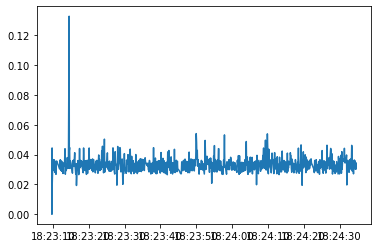

In [72]:
rtt_plot(txdf)

In [155]:
len(mpl)

44